# Setup & get data

In [121]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=30)
mpl.rc('font', size=30)
mpl.rc('xtick', labelsize=22)
mpl.rc('ytick', labelsize=22)
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn import metrics
import statistics
import math

%run -i ../scripts/pandas_startup.py

In [137]:
class suppress_stdout_stderr(object):
    """
    from https://github.com/facebook/prophet/issues/223#issuecomment-326455744
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self) -> None:
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self) -> None:
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_) -> None:
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [14]:
daily_incidents=pd.read_csv("../data/daily_incidents_clean.csv", index_col=None)

In [26]:
daily_incidents = daily_incidents[["ds", "y"]]

# Split data into training and validation (i.e., "test") sets

Make validation set as latest / most recent days.

In [27]:
validation_window = 60  # days
train_df, validation_df = train_test_split(daily_incidents, test_size=validation_window, shuffle=False)

In [28]:
assert(((len(train_df) == (len(daily_incidents)-60)) & (len(validation_df) == validation_window)))

In [29]:
train_df.head(2)

,ds,y
0,2018/01/01,214
1,2018/01/02,172


In [30]:
validation_df.head(2)

,ds,y
1492,2022/02/01,126
1493,2022/02/02,146


# Plot historical data

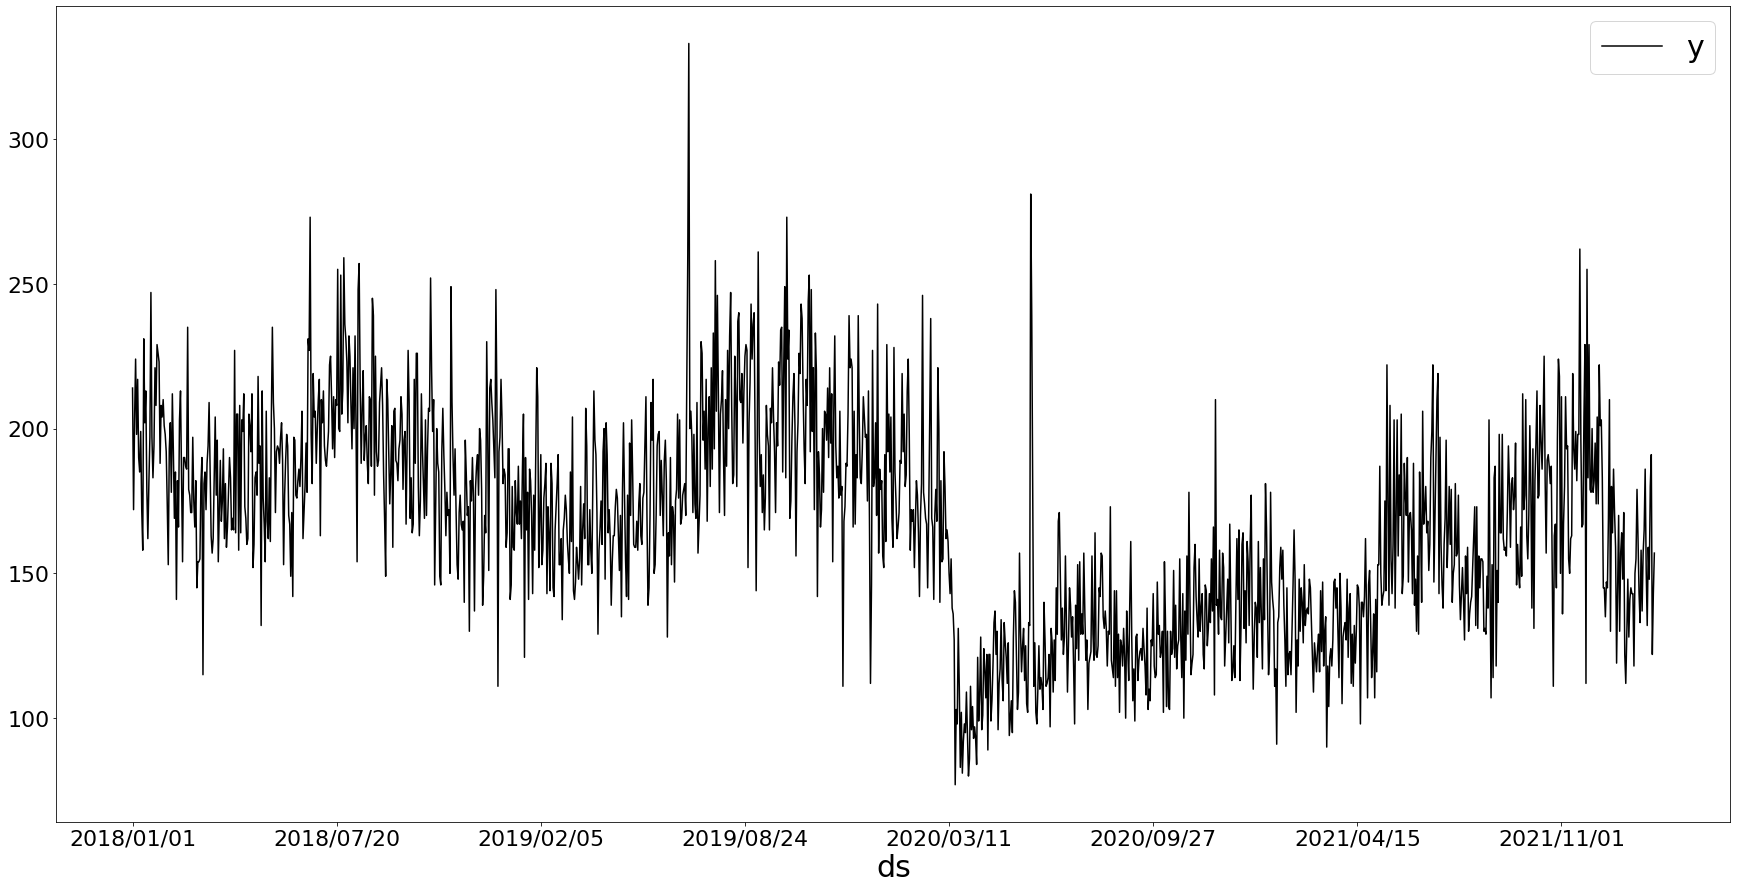

In [88]:
fig, ax = plt.subplots(figsize=(30, 15))

train_df.plot('ds', 'y', 
                     color="black", 
                     ax=ax)

plt.show()

# Forecast with basic configuration/hyperparameters

Define some basic parameters we will not be tuning (see "Parameters that would likely not be tuned" at [diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html)).

In [185]:
prophet_config_basic = {
    "yearly_seasonality": True,
    "weekly_seasonality": True,
    "daily_seasonality": True,
    "interval_width": .95
} 

prophet_forecaster_object = Prophet(**prophet_config_basic)
prophet_forecaster_object.add_country_holidays("US")
prophet_forecaster_object

If you get `Prophet' object has no attribute 'stan_backend'`, do `pip install pystan==2.19.1.1`


In [186]:
prophet_forecaster_object.fit(train_df)
train_future_df = prophet_forecaster_object.make_future_dataframe(periods=365, freq="d")
print()
print()
print("Empty rows of future dates, to fill with predictions:")
print()
print(train_future_df.sort_values)
train_forecast_df = prophet_forecaster_object.predict(train_future_df)
print()
print()
print("Predictions for future dates (yhat is the predicted value):")
print()
print(train_forecast_df[['ds', 'yhat']].tail(5))

Initial log joint probability = -11.4192


Empty rows of future dates, to fill with predictions:

<bound method DataFrame.sort_values of              ds
0    2018-01-01
1    2018-01-02
2    2018-01-03
3    2018-01-04
4    2018-01-05
...         ...
1852 2023-01-27
1853 2023-01-28
1854 2023-01-29
1855 2023-01-30
1856 2023-01-31

[1857 rows x 1 columns]>
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3208.44    0.00253801       148.596           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3215.39   0.000173889       176.656   1.324e-06       0.001      271  LS failed, Hessian reset 
     199       3216.28    0.00369201       306.012      0.5339      0.5339      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3220.71   0.000389777        59.674           1           1      429 

### Plot forecasted values

- Black are observed 
- blue line is forecasted
- light blue shaded = uncertainty intervals

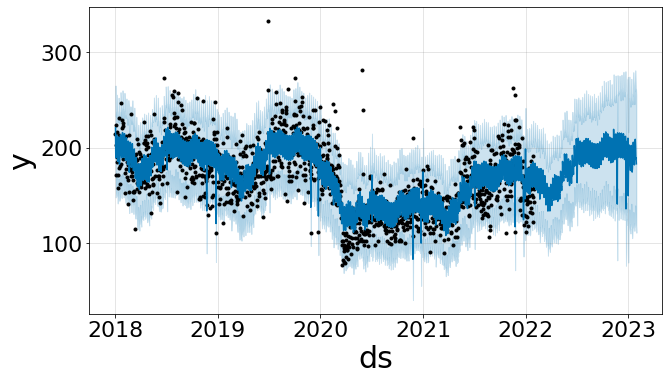

In [187]:
fig1 = prophet_forecaster_object.plot(train_forecast_df)

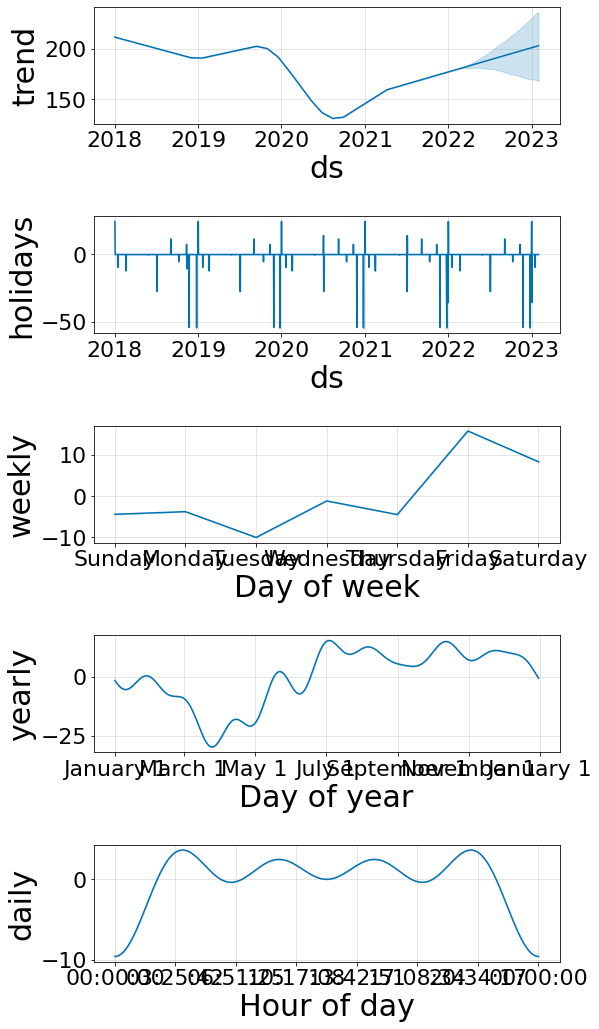

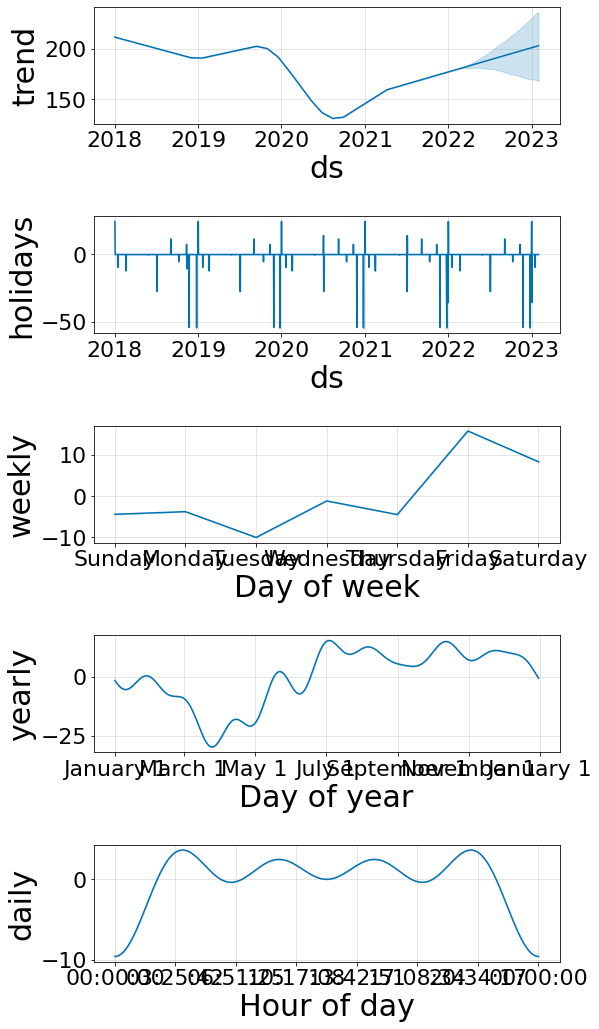

In [97]:
prophet_forecaster_object.plot_components(train_forecast_df)

## Evaluate fit

By comparing the actual values from the validation set (the latest validation_window days), with the predicted values on those dates from the training set.

In [72]:
earliest_validation_date = min(validation_df["ds"])
latest_validation_date = max(validation_df["ds"])
train_forecast_validation_dates = train_forecast_df[train_forecast_df['ds'].between(earliest_validation_date, latest_validation_date)]

MSE/RMSE is a mean, so overweights hi errors, so more sensitive to outliers than MAE.



In [80]:
print('Mean Squared Error:', mse(validation_df["y"], train_forecast_validation_dates["yhat"]))
print('Root Mean Squared Error:', np.sqrt(mse(validation_df["y"], train_forecast_validation_dates["yhat"])))
print('mean_absolute_error:', metrics.mean_absolute_error(validation_df["y"], train_forecast_validation_dates["yhat"]))


Mean Squared Error: 793.8603196763589
Root Mean Squared Error: 28.1755269635966
mean_absolute_error: 21.535891020384444


In [120]:

print("RMSE means typical prediction error of", 
      round(np.sqrt(mse(validation_df["y"], train_forecast_validation_dates["yhat"])),1), 
      "incidents on an average day. As a proportion of the mean daily incidents (",
      round((statistics.mean(df_prophet["y"])),1),
      ") that's only ",
      round((round(np.sqrt(mse(validation_df["y"], 
                               train_forecast_validation_dates["yhat"])),2))/(statistics.mean(df_prophet["y"])),2),
      ", so pretty good."      
     )

RMSE means typical prediction error of 28.2 incidents on an average day. As a proportion of the mean daily incidents ( 166.1 ) that's only  0.17 , so pretty good.


Apparently that proportion is called the coefficient of variation, AKA relative root (rRMSE) or normalized RMSE(nRMSE).
<br>
<br>Other approaches include proportion of the minimum, meaning there could be days where the error is a much larger proportion:

In [128]:
round((round(np.sqrt(mse(validation_df["y"], 
                         train_forecast_validation_dates["yhat"])),2))/(min(df_prophet["y"])),2)

0.64

Or max, meaning there could be days where the error is a much smaller proportion:

In [130]:
round((round(np.sqrt(mse(validation_df["y"], 
                         train_forecast_validation_dates["yhat"])),2))/(max(df_prophet["y"])),
      2)

0.08

# Prophet hyperparameters

https://facebook.github.io/prophet/docs/diagnostics.html

In [ ]:
from pprint import pp
import itertools
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

We'll be fitting and plotting a lot to demo hyperparameters, so make a function.

In [181]:
def fit_and_plot(prophet_forecaster_object):
    with suppress_stdout_stderr(): prophet_forecaster_object.fit(train_df)
    train_future_df = prophet_forecaster_object.make_future_dataframe(periods=365, freq="d")
    train_forecast_df = prophet_forecaster_object.predict(train_future_df)
    fig1 = prophet_forecaster_object.plot(train_forecast_df)


## `changepoint_prior_scale` 
- most impactful. 
- flexibility of the trend: how much it changes at the changepoints. 

#### Values
- Default of 0.05 works for many
- Tune in range of [0.001, 0.5] 
- This is effectively a lasso penalty; such regularization parameters are often tuned on a log scale.
    


### `changepoint_prior_scale` = .001

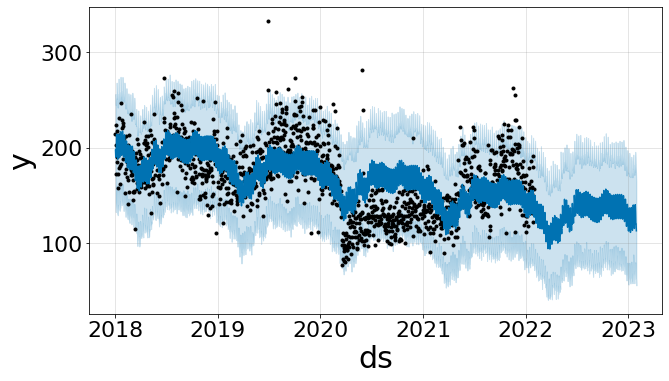

In [182]:
changepoint_prior_scale = .001
prophet_forecaster_object = Prophet(changepoint_prior_scale=changepoint_prior_scale, **prophet_config_basic)
prophet_forecaster_object.add_country_holidays("US")
fit_and_plot(prophet_forecaster_object)

### `changepoint_prior_scale` = .5

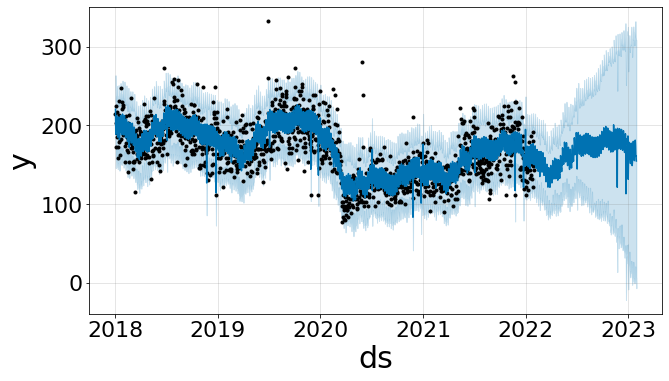

In [184]:
changepoint_prior_scale = .5
prophet_forecaster_object = Prophet(changepoint_prior_scale=changepoint_prior_scale, **prophet_config_basic)
prophet_forecaster_object.add_country_holidays("US")
fit_and_plot(prophet_forecaster_object)

`holidays_prior_scale`, `seasonality_prior_scale`, and `changepoint_range` had no effect!

## `seasonality_mode` 
- Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see [docs](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html)), but when that isn’t possible, it could be tuned.

# Tuning on a grid

In [131]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [132]:
hyperparameter_tuning(config, holidays, df_prophet, 52, 8, 24, 16)


NameError: name 'config' is not defined